In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Definiamo i nomi delle colonne
column_names = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean',
    'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
    'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst',
    'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst',
    'fractal_dimension_worst'
]

data = pd.read_csv('wdbc.data', header=None, names=column_names)

data.drop('id', axis=1, inplace=True)
le = LabelEncoder()
data['diagnosis'] = le.fit_transform(data['diagnosis'])  # 0=B, 1=M


In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=data)
plt.title('Distribuzione delle Classi nel Dataset Originale')
plt.xlabel('Diagnosi (0: Benigno, 1: Maligno)')
plt.ylabel('Conteggio')
plt.xticks([0, 1], ['Benigno (B)', 'Maligno (M)'])
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
counts = data['diagnosis'].value_counts()
labels = [f'Benigno ({counts[0]})', f'Maligno ({counts[1]})']
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribuzione a Torta delle Classi nel Dataset Originale')
plt.ylabel('')
plt.show()

In [ ]:
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)

print(f"Forma train dopo SMOTE: {X_train_sm.shape}, Classi bilanciate: {np.bincount(y_train_sm)}")

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_sm)
plt.title('Distribuzione delle Classi nel Training Set dopo SMOTE')
plt.xlabel('Diagnosi (0: Benigno, 1: Maligno)')
plt.ylabel('Conteggio')
plt.xticks([0, 1], ['Benigno (0)', 'Maligno (1)'])
plt.show()

plt.figure(figsize=(8, 8))
counts = np.bincount(y_train_sm)
labels = [f'Benigno ({counts[0]})', f'Maligno ({counts[1]})']
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribuzione a Torta delle Classi nel Training Set dopo SMOTE')
plt.ylabel('')
plt.show()

In [ ]:
cols = X_train.columns
X_train_scaled = scaler.transform(X_train)

n_cols = 5
n_rows = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 18))
axes = axes.ravel()

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(X_train_scaled[:, i], bins=30, alpha=0.5,  color='red', density=True, label='Prima')
    ax.hist(X_train_sm[:, i], bins=30, alpha=0.25, color='blue',   density=True, label='Dopo SMOTE')
    ax.set_title(col, fontsize=9)
    ax.tick_params(axis='both', labelsize=8)


axes[0].legend(fontsize=9)

plt.suptitle('Distribuzione delle features - Prima vs Dopo SMOTE', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

models = {
    'RF': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'GB': GradientBoostingClassifier(random_state=42),
    'LR': LogisticRegression(max_iter=100000, random_state=42)
}

param_grids = {
    'RF': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'KNN': {
        'n_neighbors': [5, 10, 15, 20],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'GB': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10, 15],
        'subsample': [0.8, 1.0]
    },
    'LR': [
        {
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear']
        },
        {
            'penalty': ['l2'],
            'C': [0.1, 1, 10, 100],
            'solver': ['lbfgs']
        }
    ]
}

best_models = {}
for name, model in models.items():
    print(f"--- {name} ---")
    grid = GridSearchCV(model, param_grids[name], cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_sm, y_train_sm)

    best_models[name] = grid.best_estimator_
    
    print(f"Migliori parametri: {grid.best_params_}")

    # Valutazione sul test set
    y_pred_test = best_models[name].predict(X_test)
    print("\nReport di classificazione sul test set:")
    print(classification_report(y_test, y_pred_test, target_names=['Benigno (0)', 'Maligno (1)']))
    print("\n" + "="*60 + "\n")

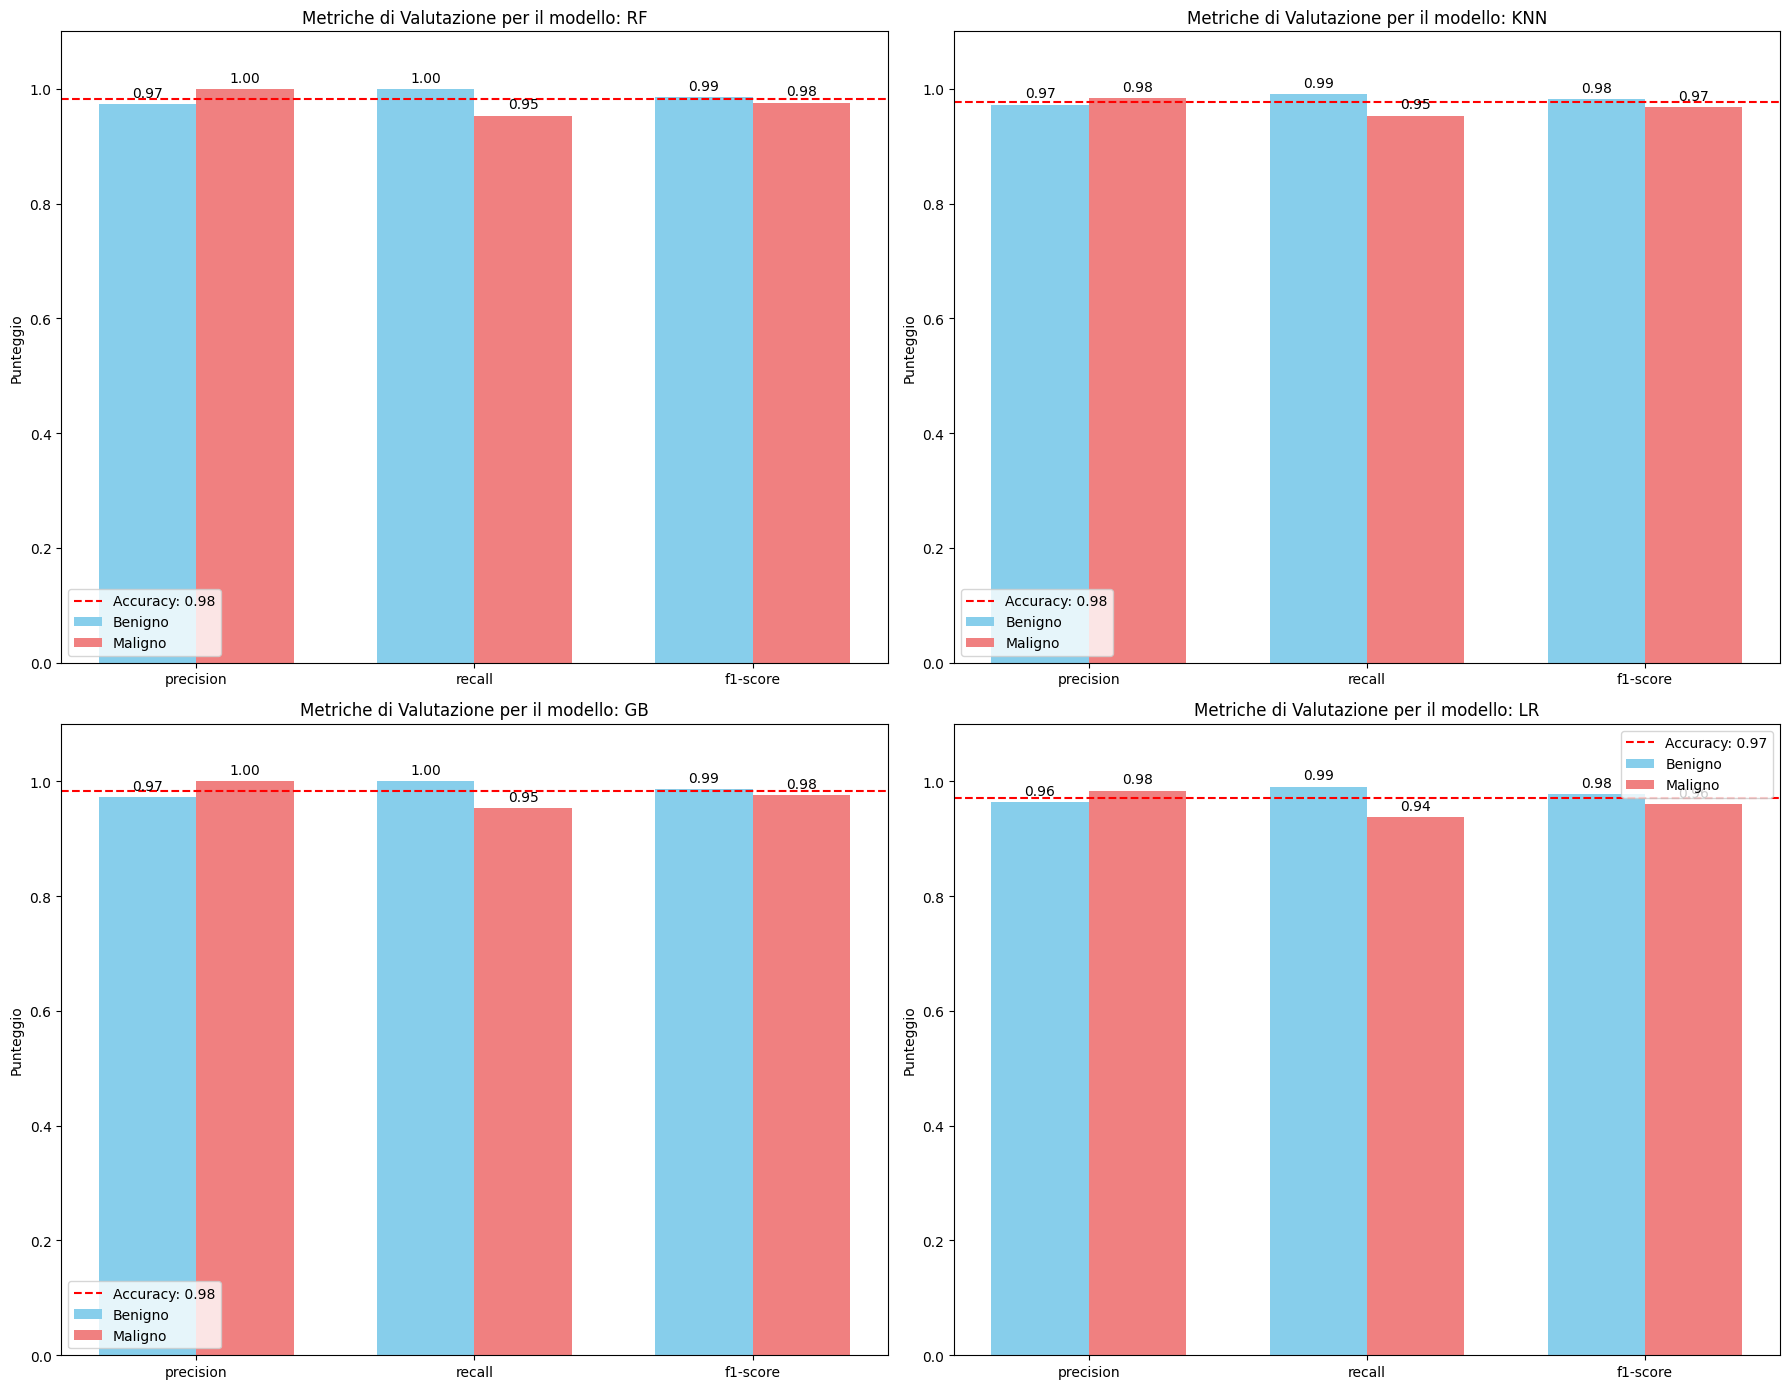

Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-13861-rttzkzgu for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-13861-qaz72fh_ for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-13861-io5swt6g for automatic clea

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

class_names = ['Benigno', 'Maligno']
metrics_to_plot = ['precision', 'recall', 'f1-score']

for i, (name, model) in enumerate(best_models.items()):
    ax = axes[i]
    
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    benign_metrics = [report[class_names[0]][m] for m in metrics_to_plot]
    malign_metrics = [report[class_names[1]][m] for m in metrics_to_plot]
    
    accuracy = report['accuracy']
    
    x = np.arange(len(metrics_to_plot))
    width = 0.35

    rects1 = ax.bar(x - width/2, benign_metrics, width, label=class_names[0], color='skyblue')
    rects2 = ax.bar(x + width/2, malign_metrics, width, label=class_names[1], color='lightcoral')
    
    ax.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy: {accuracy:.2f}')

    ax.set_ylabel('Punteggio')
    ax.set_title(f'Metriche di Valutazione per il modello: {name}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot)
    if name == 'GB':
        ax.legend(loc='lower left')
    else:
        ax.legend()
    ax.set_ylim(0, 1.1)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

plt.tight_layout()
plt.show()